In [ ]:
!pip install pandas
!pip install scipy
!pip install matplotlib
!pip install brainflow

In [ ]:
import time
import numpy as np
import pandas as pd
import openpyxl
import matplotlib.pyplot as plt
import argparse
import scipy
from scipy.signal import filtfilt
from scipy import stats
import brainflow
from brainflow.board_shim import BoardShim, BrainFlowInputParams
from brainflow.data_filter import DataFilter, FilterTypes, AggOperations,DetrendOperations

In [ ]:
########################################################
###########Configuración de la placa####################
########################################################

#inicializamos la placa cyton en stand by
BoardShim.enable_dev_board_logger()
#definimos parametros, numero de placa y puerto serie donde este conectada.
params = BrainFlowInputParams()
params.serial_port = 'COM4'
board = BoardShim(0,params)

########################################################
###########  Adquisicion de datos   ####################
########################################################
#iniciamos sesion.
board.prepare_session()
board.start_stream () # use this for default options

#dejamos pasar 1 segundo
time.sleep(1)
# data = board.get_current_board_data (250) # get latest 256 packages or less, doesnt remove them from internal buffer

#Obtenemos la informacion de ese segundo y limpiamos buffer
data = board.get_board_data() #get all data and remove it from internal buffer
#dejamos pasar otro segundo
time.sleep(1)

#En este rudimentario loop a=cantidad de segundos a almacenar de info en "data"
#(recordar que data ya tiene 1 segundo almacenado)
a=30
paso=a+1
while a!= 0:
    data= np.concatenate((data , board.get_board_data()), axis=1)
    #Vamos concatenando la data de cada intervalo de tiempo
    a=a-1
    time.sleep(1)
    print(a)

#---------------------------------------------------------------------
#Data tiene toda la informacion de la placa, de todos los canales
# y de todos los sensores y demas, a nosotros nos importan las filas 1 a 8
#Las mismas tienen los 8 canales correspondientes.
#---------------------------------------------------------------------

#Paramos de streamear
board.stop_stream()
board.release_session()

# df2n=np.array(df2)
# df2n =df2n.transpose()
# df2n[0]

29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1
0


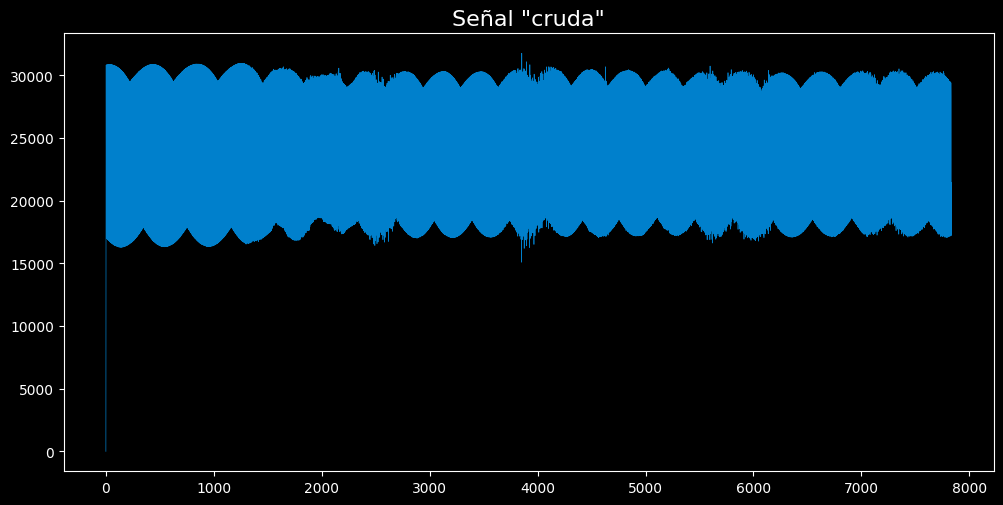

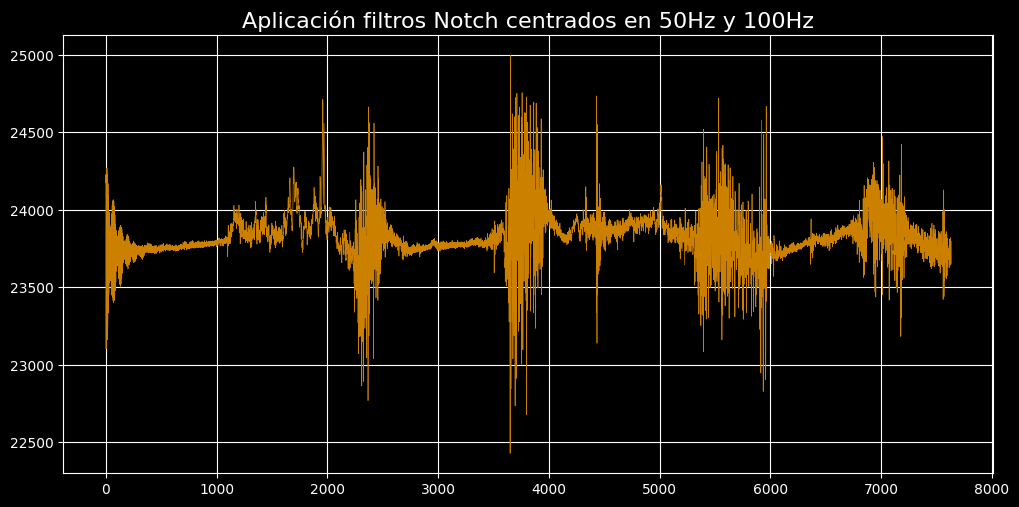

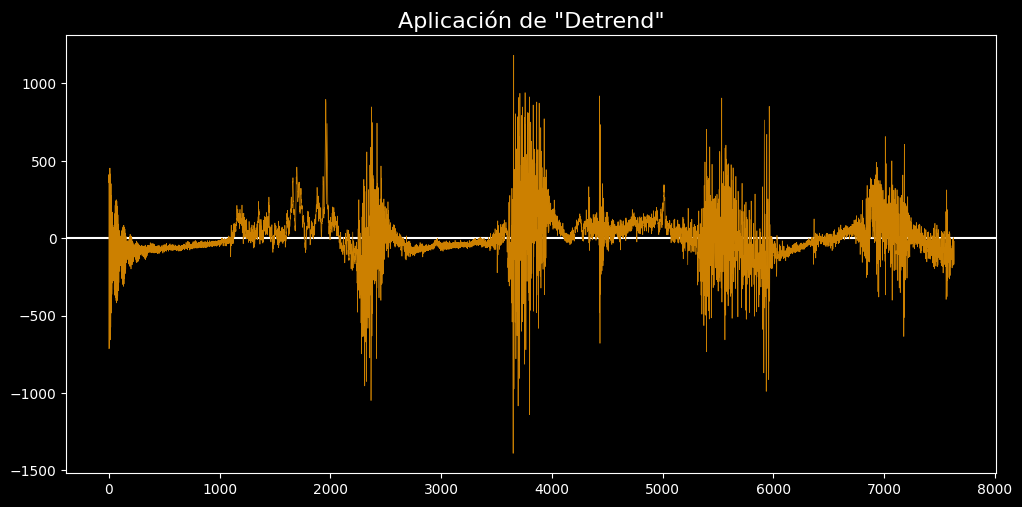

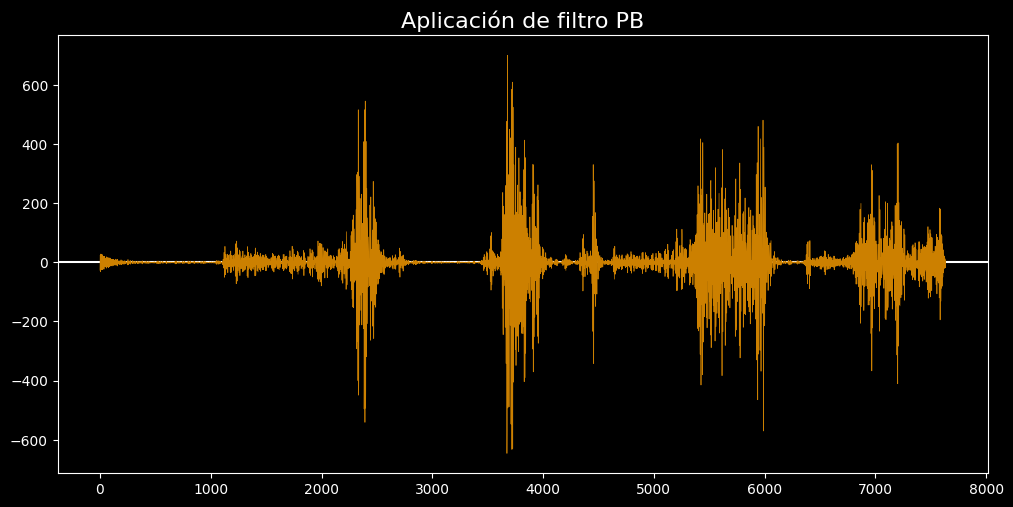

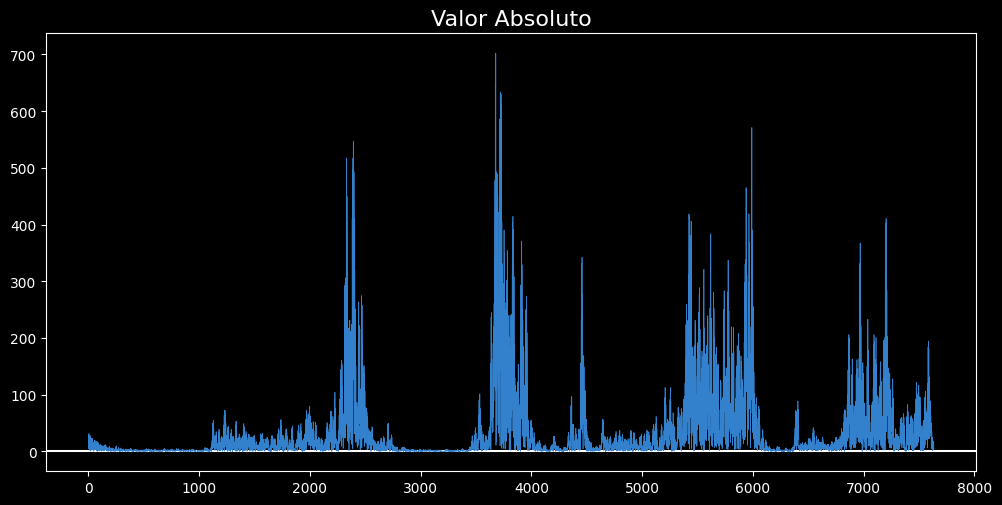

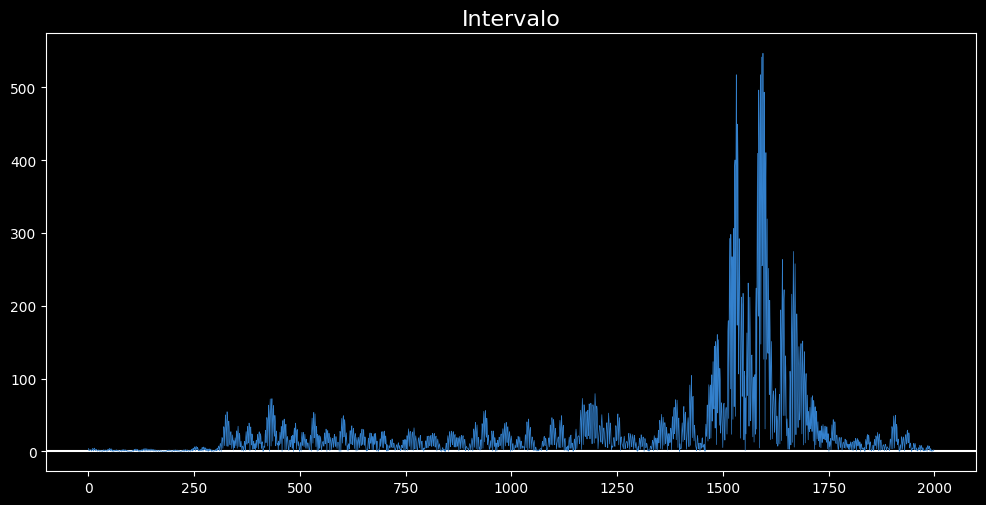

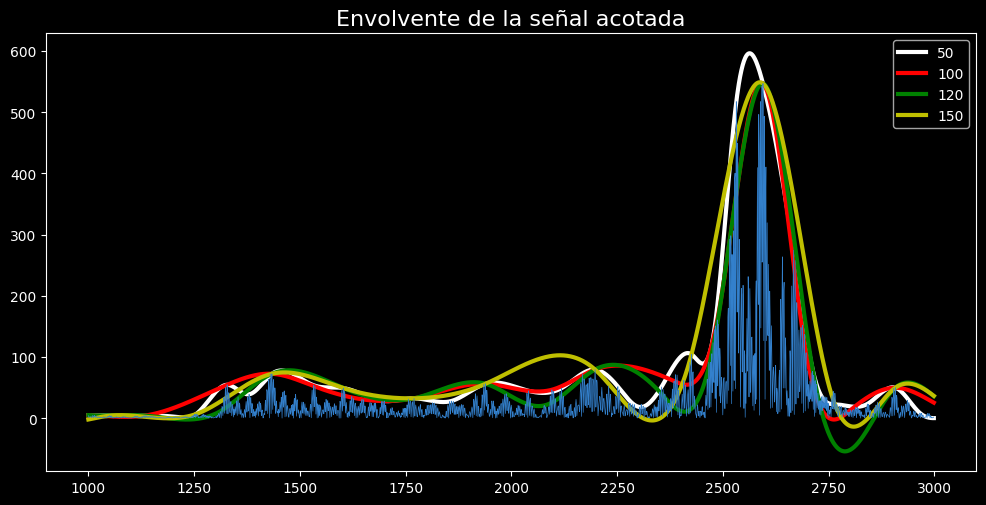

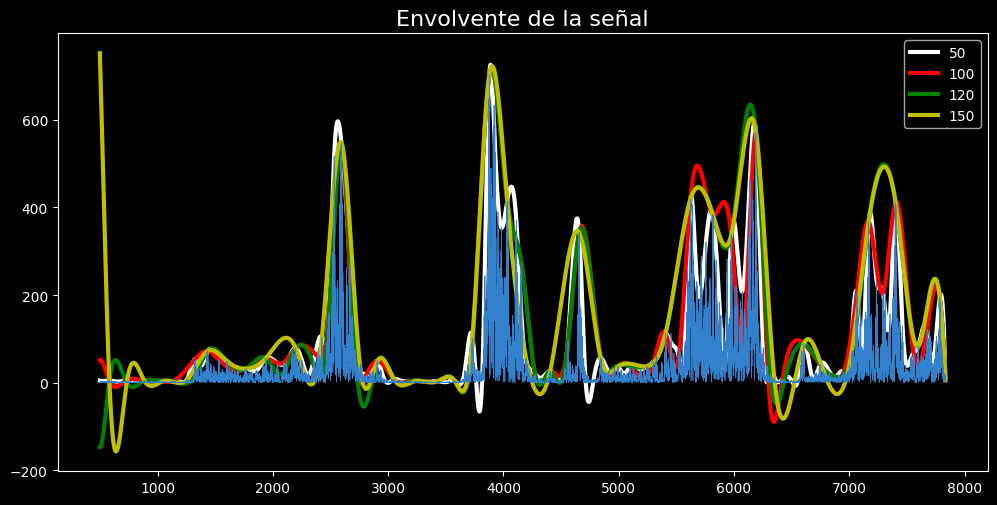

In [ ]:
########################################################
###########  Filtrado y visualización  ####################
########################################################
plt.style.use('dark_background')
plt.rcParams["figure.dpi"] = 100
data_f=np.array(data[1])
plt.figure(figsize=(12,5.8))
plt.title('Señal "cruda"',fontsize=16)
plt.plot(np.arange(0,len(data[1]),1),data[1],linewidth=0.5, color=(0,0.5,0.8,1))

################################Filtros Notch########################################
DataFilter.perform_bandstop(data_f, 250,
                                50.0, 4.0, 8,
                                FilterTypes.BUTTERWORTH.value, 0)
DataFilter.perform_bandstop(data_f, 250,
                                100.0, 4.0, 2,
                                FilterTypes.BUTTERWORTH.value, 0)

plt.figure(figsize=(12,5.8))
plt.grid() #grilla
plt.title('Aplicación filtros Notch centrados en 50Hz y 100Hz',fontsize=16)
plt.plot(np.arange(0,len(data_f[200:]),1),data_f[200:],linewidth=0.5, color=(0.8,0.5,0,1))
################################Filtros Notch########################################

###################################Detrend########################################
DataFilter.detrend(data_f, DetrendOperations.CONSTANT.value)
plt.figure(figsize=(12,5.8))
plt.title('Aplicación de "Detrend"',fontsize=16)
plt.axhline(y=0, color='w')
plt.plot(np.arange(0,len(data_f[200:]),1),data_f[200:],linewidth=0.5, color=(0.8,0.5,0,1))
###################################Detrend########################################

###############################Filtro Pasa Banda########################################
DataFilter.perform_bandpass(data_f, 250, 33
                                , 20, 8,
                               FilterTypes.BUTTERWORTH.value,0)
# BUTTERWORTH  CHEBYSHEV_TYPE_1 = 1  #:      BESSEL = 2  #: 30 centro 20 ancho anda bien
plt.figure(figsize=(12,5.8))
plt.title('Aplicación de filtro PB',fontsize=16)
plt.axhline(y=0, color='w')
plt.plot(np.arange(0,len(data_f[200:]),1),data_f[200:],linewidth=0.5, color=(0.8,0.5,0,1))
plt.show()
###############################Filtro Pasa Banda########################################

###############################Valor Absoluto########################################
a=0
for f in data_f:
    data_f[a]=abs(f)
    a=a+1

#Señal completa
plt.figure(figsize=(12,5.8))
plt.title('Valor Absoluto',fontsize=16)
plt.axhline(y=0, color='w')
plt.plot(np.arange(0,len(data_f[200:]),1),data_f[200:],linewidth=0.5, color=(0.2,0.5,0.8,1))
plt.show()

#Señal acotada
plt.figure(figsize=(12,5.8))
plt.title('Intervalo',fontsize=16)
plt.axhline(y=0, color='w')
plt.plot(np.arange(0,len(data_f[1000:3000]),1),data_f[1000:3000],linewidth=0.5, color=(0.2,0.5,0.8,1))
plt.show()
###############################Valor Absoluto########################################

##############################Envolvente de la señal##############################
import scipy.interpolate
data_f_env=np.array(data_f)
t=np.arange(len(data_f_env))
def envelope(sig, distance):
    # split signal into negative and positive parts
    u_x = np.where(sig > 0)[0]
    u_y = sig.copy()

    # find upper peaks
    u_peaks, _ = scipy.signal.find_peaks(u_y, distance=distance)

    # use peaks and peak values to make envelope
    u_x = u_peaks
    u_y = sig[u_peaks]

    # add start and end of signal to allow proper indexing
    end = len(sig)
    u_x = np.concatenate((u_x, [0, end]))
    u_y = np.concatenate((u_y, [0, 0]))

    # create envelope functions
    u = scipy.interpolate.interp1d(u_x, u_y,kind='cubic')
    return u


x = np.arange(len(data_f_env))
sig = data_f_env
u = envelope(sig, 50)
uu = envelope(sig, 100)
uuu = envelope(sig, 120)
uuuu = envelope(sig, 150)

plt.figure(figsize=(12,5.8))
plt.title('Envolvente de la señal acotada',fontsize=16)
plt.plot(x[1000:3000], u(x[1000:3000]),color='w',linewidth=3)
plt.plot(x[1000:3000], uu(x[1000:3000]),color='r',linewidth=3)
plt.plot(x[1000:3000], uuu(x[1000:3000]),color='g',linewidth=3)
plt.plot(x[1000:3000], uuuu(x[1000:3000]),color='y',linewidth=3)
plt.plot(x[1000:3000], sig[1000:3000],color=(0.2,0.5,0.8,1),linewidth=0.5)
plt.legend(['50','100','120','150'])
plt.show()

plt.figure(figsize=(12,5.8))
plt.title('Envolvente de la señal',fontsize=16)
plt.plot(x[500:], u(x[500:]),color='w',linewidth=3)
plt.plot(x[500:], uu(x[500:]),color='r',linewidth=3)
plt.plot(x[500:], uuu(x[500:]),color='g',linewidth=3)
plt.plot(x[500:], uuuu(x[500:]),color='y',linewidth=3)
plt.plot(x[500:], sig[500:],color=(0.2,0.5,0.8,1),linewidth=0.5)
plt.legend(['50','100','120','150'])
plt.show()
##############################Envolvente de la señal##############################


In [ ]:
# character	color
# ‘b’	blue
# ‘g’	green
# ‘r’	red
# ‘c’	cyan
# ‘m’	magenta
# ‘y’	yellow
# ‘k’	black
# ‘w’	white

In [ ]:
#####################################################################################
#Esta celda solo apaga el stream para liberar el puerto, ya que queda conectado si hay un error
#####################################################################################
board.stop_stream()
board.release_session()


In [ ]:
#####################################################################################
######################### Almacenado en Excel #######################################
#####################################################################################

#Utilizamos pandas, convertimos a dataframe y enviamos a excel
pd.DataFrame(data).to_excel('EMG8canales.xlsx', header=False, index=False)
